In [53]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import datetime

pd.plotting.register_matplotlib_converters()

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [12, 6]

# Data laden

In [54]:
data_path = "../data/origineel"
if not Path(data_path).is_dir():
    raise Warning("Data path does not exist")

In [55]:
# Lijst van .csv-bestanden
data_file_paths = [path for path in Path(data_path).iterdir() if path.suffix==".csv"]

# Geef het circuitnummer (4 cijfers) dat in de naam van een Path staat
circuitnum_from_file_path = lambda file_path: int(file_path.name.split('-')[0])

# Drie dictionaries, met als keys de circuitnummers (int), als value de Pandas DataFrame van de .csv.
cable_config       = {circuitnum_from_file_path(fp): pd.read_csv(fp, sep=";") for fp in data_file_paths if 'cableconfig' in fp.name}
partial_discharges = {circuitnum_from_file_path(fp): pd.read_csv(fp, sep=";") for fp in data_file_paths if 'pd' in fp.name}
warning            = {circuitnum_from_file_path(fp): pd.read_csv(fp, sep=";") for fp in data_file_paths if 'warning' in fp.name}

# Sla de keys op van alle kabels waarvoor PD data bestaat.
circuits = list(cable_config)
circuits.sort()
print(circuits)

[1512, 2063, 2145, 2806, 2870, 2979, 2980, 3010]


In [56]:
print("Cable config loaded for circuits:", list(cable_config))
print("   PD series loaded for circuits:", list(partial_discharges))
print("Warning logs loaded for circuits:", list(warning))

Cable config loaded for circuits: [2145, 3010, 2979, 2980, 2806, 2870, 1512, 2063]
   PD series loaded for circuits: [2145, 3010, 2979, 2980, 2806, 2870, 1512, 2063]
Warning logs loaded for circuits: [1512, 2145, 2806, 2870, 2063]


In [57]:
# Kies een circuit uit
circ = circuits[1]
print(circ)

# Lengte van de kabel is gegeven in de cable config
cable_length = cable_config[circ]['Cumulative length (m)'].values[-1]
pd = partial_discharges[circ]

# Sla de drie kolomnamen van PD voor het gemak op
datetime_column, location_column, charge_column = pd.columns

# Lijst met bools die aangeeft of er op dat tijdstip een PD was
pd_occured = ~np.isnan(pd[location_column])

# De drie kolommen; alleen op tijdstippen met PD
locations = pd[location_column][pd_occured]
charges = pd[charge_column][pd_occured]
convert_times = lambda date_string: datetime.datetime.strptime(date_string, "%Y-%m-%d %H:%M:%S")
times = pd[datetime_column][pd_occured].apply(convert_times)

charge_threshold = 1500
big_charge = charges > charge_threshold

locations = locations.loc[big_charge.values]
charges = charges.loc[big_charge.values]
times = times.loc[big_charge.values]

2063


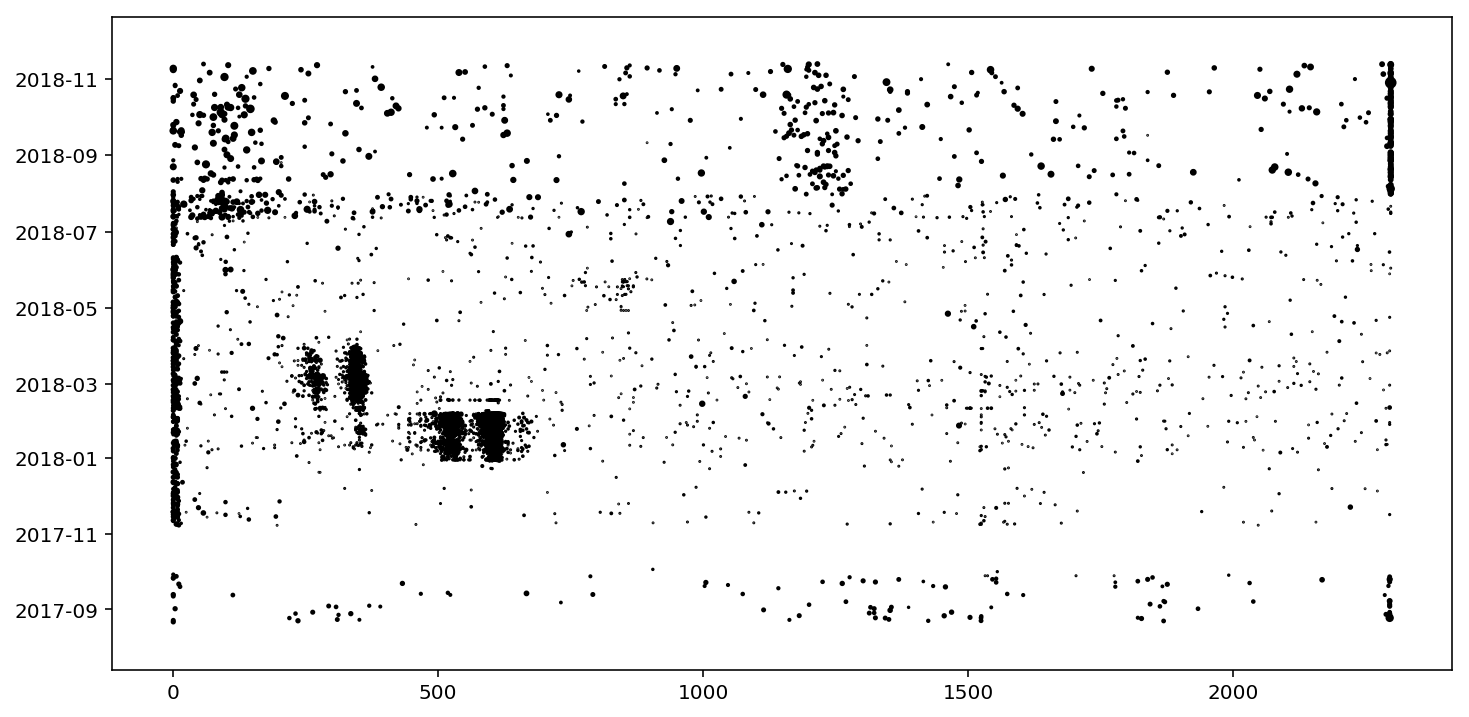

,Component type,Length (m),Cumulative length (m)
0,RMU,NaN,0.0
1,Termination (unknown),NaN,0.0
2,"Cable (PILC, 3 cores, belted)",12.0,12.0
3,Joint (resin),NaN,12.0
4,"Cable (PILC, 3 cores, belted)",16.0,28.0
5,Joint (oil),NaN,28.0
6,"Cable (PILC, 3 cores, belted)",84.0,112.0
7,Joint (oil),NaN,112.0
8,"Cable (PILC, 3 cores, belted)",242.0,354.0
9,Joint (resin),NaN,354.0


In [58]:
plt.scatter(x=locations, y=times, s=charges/1e4, c='.0')
plt.show()

cable_config[circ]

# Algoritme

In [106]:
location_bins_number = 500
time_bins_number = 1

timestamps = times.apply(datetime.datetime.timestamp)
H, xedges, yedges = np.histogram2d(timestamps, locations, bins=[time_bins_number, location_bins_number])#, weights=charges)
from_timestamp = np.vectorize(lambda x: datetime.datetime.fromtimestamp(x))
yedges_datetime = from_timestamp(yedges)

In [107]:
def average(H, nxbins, nybins):
    total = 0
    for i in range(nxbins):
        for j in range(nybins):
            total += H[i][j]
    return total/(nxbins*nybins)

In [108]:
print(average(H, xedges.size-1, yedges.size-1))

24.486


In [109]:
lower_limit_nominal = 90.0/100.0
nominal_pd_level = np.sort(H.flat)[int(lower_limit_nominal * len(H.flat))]
print(nominal_pd_level)

15.0


In [110]:
boolean_pds = H>nominal_pd_level
int_pds = boolean_pds.astype(int)

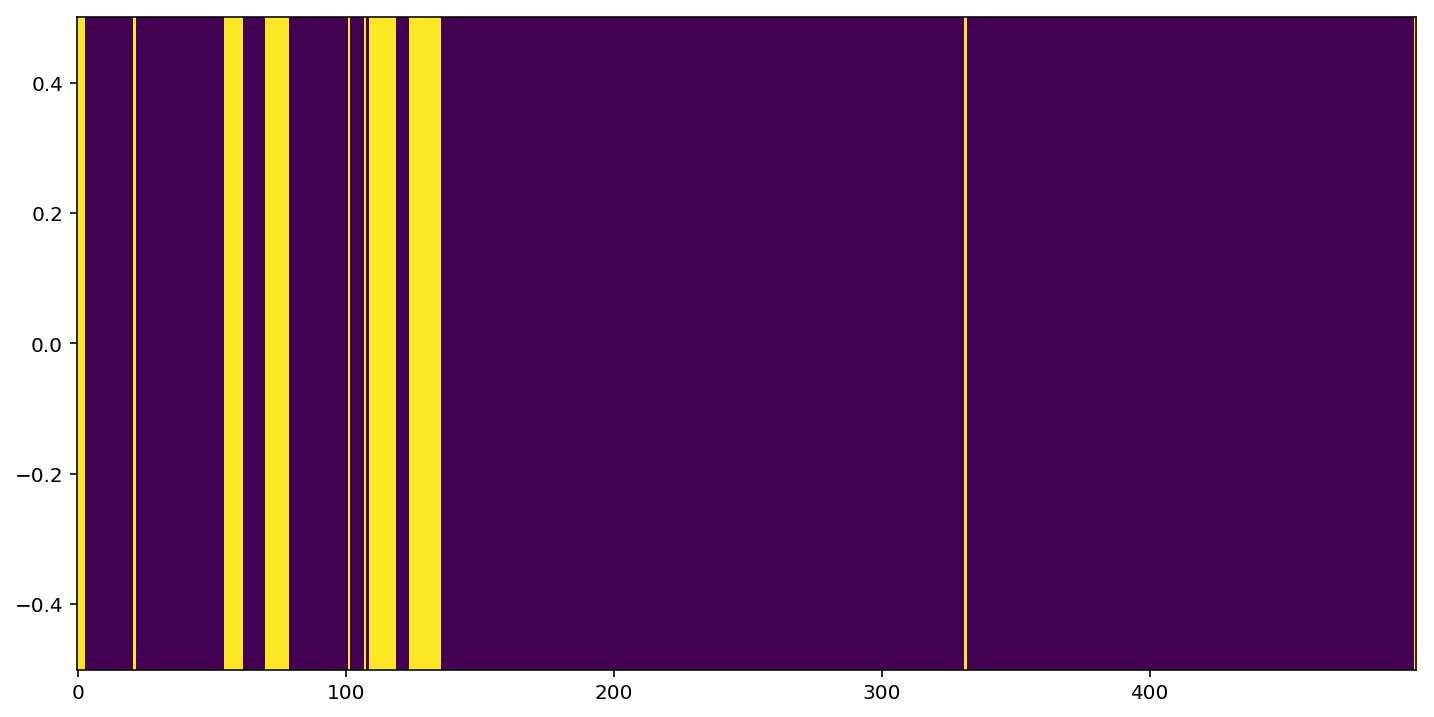

In [111]:
plt.imshow(int_pds, origin="lower", aspect='auto')

In [112]:
square = lambda x: x*x

phieta = scipy.stats.norm.ppf(q=lower_limit_nominal)
rate = .25*square(-phieta + np.sqrt(square(phieta) + 4*nominal_pd_level))
print(rate)

lower_limit_fault = 99.9/100.0
fault_pd_level = scipy.stats.norm.ppf(q=lower_limit_fault, loc=rate, scale=rate)
print(fault_pd_level)

10.790286228909965
44.13477732628555


In [113]:
boolean_pds_fault = H>fault_pd_level
int_pds_fault = boolean_pds_fault.astype(int)

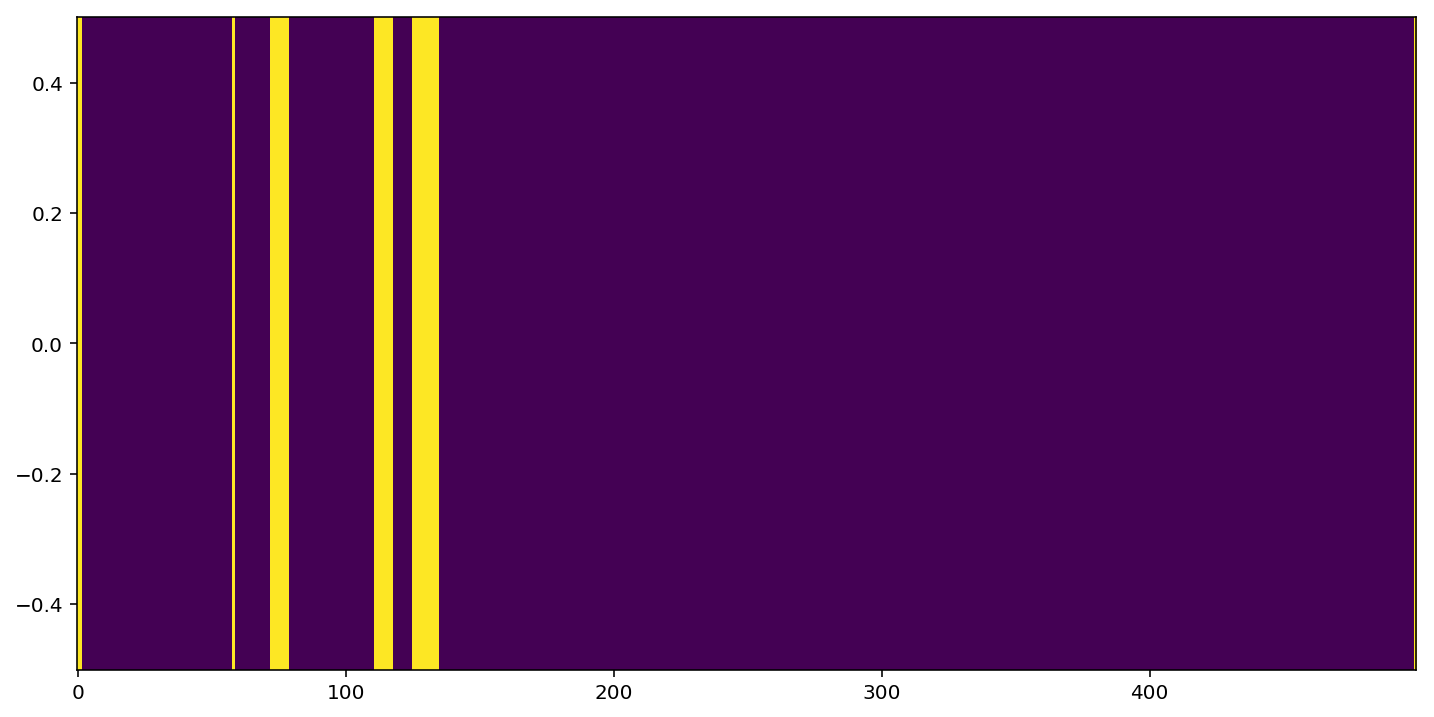

In [114]:
plt.figure(figsize=(5,5))
plt.clf()
plt.close()
plt.imshow(int_pds_fault, origin="lower", aspect='auto')

In [115]:
count_truelost = 0
count_truegained = 0
count_same = 0
count_true_now = 0
for i in range(xedges.size-1):
    for j in range(yedges.size-1):
        if(boolean_pds[i][j] and not boolean_pds_fault[i][j]):
            count_truelost += 1
        elif(boolean_pds[i][j] != boolean_pds_fault[i][j]):
            count_truegained += 1
        else:
            count_same += 1
        if(boolean_pds_fault[i][j]):
            count_true_now += 1

print("True: " + str(count_true_now))
print("True lost: " + str(count_truelost))
print("True gained: " + str(count_truegained))
print("Same: " + str(count_same))

True: 28
True lost: 18
True gained: 0
Same: 482
